In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
from torch_geometric.data import Data

In [2]:
def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

path_to_training = Path("data/training")
path_to_test = Path("data/test")

#####
# training and test sets of transcription ids
#####
training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')

test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])

In [3]:
graph_links_labels= set()
for id in training_set:
    with open(path_to_training / f"{id}.txt", "r") as graphe:
        for line in graphe:
            l = line.split()
            graph_links_labels.add(l[1])
L = list(graph_links_labels)
int2label = {indice: valeur for indice, valeur in enumerate(L)}
label2int = {valeur: indice for indice, valeur in enumerate(L)}
label2int
N_vocab_links = len(L)
print(N_vocab_links)

16


In [4]:
def extract_training():

    N_files = len(training_set)
    D_embedding = 384

    graphs = [] 

    # lets got throug all training graphs
    for k, transcription_id in enumerate(training_set):
        #nodes
        bert_array = np.load('feature-extraction/bert/training/' + transcription_id +'.npy')
        x = torch.tensor(bert_array.reshape(-1,384), dtype=torch.float)
        #edges
        edges = [[] for _ in range(33)]
        with open(path_to_training / f"{transcription_id}.txt", "r") as graphe:
            for line in graphe:
                l = line.split()
                i = int(l[0])
                j =  int(l[2])
                edge_type = label2int[l[1]] - 1
                edges[edge_type].append([i,j])
                edges[16 + edge_type].append([i,j])
        for i in range(len(x)):
            edges[32].append([i,i])
        edges = [torch.tensor(edges[k]).t().contiguous() for k in range(33)]
        #labels
        with open("data/training_labels.json", "r") as file:
            training_labels = json.load(file)
        labels = torch.tensor(np.array(training_labels[transcription_id]))
        graph = Data(x=x, edge_index=edges, y=labels)
        graphs.append(graph)
    return graphs

def extract_test():

    N_files = len(training_set)
    D_embedding = 384

    graphs = [] 

    # lets got throug all training graphs
    for k, transcription_id in enumerate(test_set):
        #nodes
        bert_array = np.load('feature-extraction/bert/test/' + transcription_id +'.npy')
        x = torch.tensor(bert_array.reshape(-1,384), dtype=torch.float)
        #edges
        edges = [[] for _ in range(33)]
        with open(path_to_test / f"{transcription_id}.txt", "r") as graphe:
            for line in graphe:
                l = line.split()
                i = int(l[0])
                j =  int(l[2])
                edge_type = label2int[l[1]] - 1
                edges[edge_type].append([i,j])
                edges[16 + edge_type].append([i,j])
        for i in range(len(x)):
            edges[32].append([i,i])
        edges = [torch.tensor(edges[k]).t().contiguous() for k in range(33)]
        
        graph = Data(x=x, edge_index=edges)
        graphs.append(graph)
    return graphs


In [5]:
from torch_geometric.loader import DataLoader

data = extract_training()

data_test_kagle = extract_test()

nb_test = 20

data_train = data[:-nb_test]
data_test = data[-nb_test:]
train_loader = DataLoader(data_train)
test_loader = DataLoader(data_test)

In [6]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class NodeClassifier(torch.nn.Module):
    def __init__(self, channels, input_dim):
        super(NodeClassifier, self).__init__()
        self.channels = channels
        self.sc1 = 100
        self.f1 = 50
        self.sc2 = 30
        self.GCN1 = nn.ModuleList([GCNConv(input_dim, self.sc1) for _ in range(channels)])
        self.dense1 = nn.Linear(self.sc1*channels, self.f1)
        self.GCN2 = nn.ModuleList([GCNConv(self.f1, self.sc2) for _ in range(channels)])
        self.dense2 = nn.Linear(self.sc2*channels, 2)

    def forward(self, data):
        nodes, edges = data.x, data.edge_index
        # Appliquez les couches GCN avec une activation ReLU entre elles
        x1 = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.sc1)
            else:
                x = F.relu(self.GCN1[k](nodes, edges[k]))
            x1.append(x)
        x1_f = torch.cat(x1, dim=1)

        f1 = F.relu(self.dense1(x1_f))

        x2 = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.sc2)
            else:
                x = F.relu(self.GCN2[k](f1, edges[k]))
            x1.append(x)
            x2.append(x)
        x2_f = torch.cat(x2, dim=1)

        x_out = self.dense2(x2_f)

        return F.log_softmax(x_out, dim=1)



In [7]:
from sklearn.metrics import confusion_matrix

def f1_score(y_pred, y_real):
    conf_matrix = confusion_matrix(y_real, y_pred)
    tp, fp, fn, tn = conf_matrix[1, 1], conf_matrix[0, 1], conf_matrix[1, 0], conf_matrix[0, 0]
    if (tp + fp) == 0:
        return 0
    if (tp + fn) == 0:
        return 0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision + recall) == 0:
        return 0
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [8]:

# Entraînez le modèle
def train(model, train_loader, optimizer, criterion,):
    model.train()
    loss_tot = 0
    for data in train_loader:
        optimizer.zero_grad()  # Clear gradients.
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out, data.y.long())  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        loss_tot += loss
    return loss_tot

def test_during_training(model, validation_loader):
    model.eval()
    S = 0
    for data in validation_loader:
        predicted = prediction(model, data)
        f1 = f1_score(predicted, data.y.numpy())
        S += f1
    f1_moyen = S / len(test_loader)
    print(f'F1-score: {f1_moyen}')

def prediction(model, graph):
    model.eval()
    out = model(graph)
    _, predicted = torch.max(out, 1)
    return predicted.numpy()



In [9]:
# Instanciez le modèle
model = NodeClassifier(33,384)

# Définissez la fonction de perte et l'optimiseur
f = 0.3
#criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1-f, f]))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [10]:
print("-----------------------------")
print('Data')
ones = sum([np.sum(g.y.numpy()) for g in data])
tot_nodes = sum([g.x.numpy().shape[0] for g in data])
print(ones, 'labels 1 sur ',tot_nodes,'noeuds soit', 100*ones/tot_nodes, '%')
print("-----------------------------")
print('Training set :', len(data_train),'graphs')
ones = sum([np.sum(g.y.numpy()) for g in data_train])
tot_nodes = sum([g.x.numpy().shape[0] for g in data_train])
print(ones, 'labels 1 sur ',tot_nodes,'noeuds soit', 100*ones/tot_nodes, '%')
print('Testing set :', len(data_test))
ones_test = sum([np.sum(g.y.numpy()) for g in data_test])
tot_nodes_test = sum([g.x.numpy().shape[0] for g in data_test])
print(ones_test, 'labels 1 sur ',tot_nodes_test,'noeuds soit', 100*ones_test/tot_nodes_test, '%')
print("-----------------------------")

for epoch in range(3):
    loss = train(model, train_loader, optimizer, criterion)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    test_during_training(model, test_loader)

ones_predicted = sum([np.sum(prediction(model, g)) for g in test_loader])
print("-----------------------------")
print("Test du modèle :")
print(ones_predicted, 'label 1 prédits sur les ',ones_test,'voulus (',100 * ones_predicted/tot_nodes_test,'%)')

-----------------------------
Data
13292 labels 1 sur  72623 noeuds soit 18.30274155570549 %
-----------------------------
Training set : 77 graphs
10580 labels 1 sur  53802 noeuds soit 19.66469647968477 %
Testing set : 20
2712 labels 1 sur  18821 noeuds soit 14.409436267998512 %
-----------------------------
Epoch: 000, Loss: 31.6019
F1-score: 0.4838454733227497
Epoch: 001, Loss: 26.7909
F1-score: 0.4987080272397703
Epoch: 002, Loss: 25.6384
F1-score: 0.5027416328473369
-----------------------------
Test du modèle :
4140 label 1 prédits sur les  2712 voulus ( 21.996705807342863 %)


In [11]:
prediction(data_test[0])

TypeError: prediction() missing 1 required positional argument: 'graph'

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def analyse_model(model, test_loader):
    model.eval()
    S = 0
    global_conf_matrix = np.zeros((2,2))
    global_proba_matrix = np.zeros((2,2))
    for data in test_loader:
        out = model(data)
        _, predicted = torch.max(out, 1)
        y_pred = predicted.numpy()
        y_true = data.y.numpy()
        conf_matrix = confusion_matrix(y_true, y_pred)
        proba_matrix = 
        global_conf_matrix += conf_matrix
        f1 = f1_score(y_pred, y_true)
        S += f1
    f1_moyen = S / len(test_loader)
    print('F1-score:',f1_moyen)
    plt.figure(figsize=(3, 3))
    sns.heatmap(global_conf_matrix, annot=True, cmap="Blues", cbar=False,
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

F1-score: 0.49786984108400045


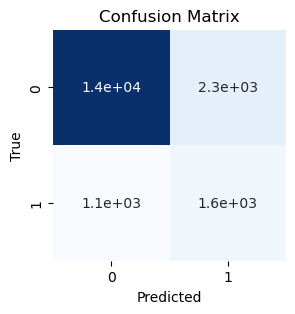

In [ ]:
analyse_model(model, test_loader)

In [ ]:
print(len(data_test_kagle))

40


In [ ]:
test_labels = {}
for i, graph in enumerate(data_test_kagle):
    id = test_set[i]
    y_test = prediction(graph)
    test_labels[id] = y_test.tolist()

with open("test_labels_GNN.json", "w") as file:
    json.dump(test_labels, file, indent=4)

ES2003a
ES2003b
ES2003c
ES2003d
ES2004a
ES2004b
ES2004c
ES2004d
ES2011a
ES2011b
ES2011c
ES2011d
ES2014a
ES2014b
ES2014c
ES2014d
IS1008a
IS1008b
IS1008c
IS1008d
IS1009a
IS1009b
IS1009c
IS1009d
TS3003a
TS3003b
TS3003c
TS3003d
TS3004a
TS3004b
TS3004c
TS3004d
TS3006a
TS3006b
TS3006c
TS3006d
TS3007a
TS3007b
TS3007c
TS3007d
